In [1]:
from csv import reader
import pandas as pd
import numpy as np

import random
import sys

import os
import shutil

# from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import silhouette_score

import time

# genetic algorithm search of the one max optimization problem
from numpy.random import randint
from numpy.random import rand


import Scripts.LevenClustering as levenClustering
import Scripts.SeqCleaning as seqCleaning


In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

output = "Puzzles_Output"
# file = ['00 Result/SelectionF15/puzzle_1.csv', '00 Result/SelectionS16/puzzle_1.csv']
file = ['Puzzles_CSV/Puzzle_1.csv']

In [4]:
### functions for GA environment
def convert_to_decimal(binary_list):
    res = int("".join(str(x) for x in binary_list), 2)
    
    return int(res)

def convert_to_binary(decimal_num):
    res = format(decimal_num, "08b")
    res = [int(x) for x in res]
    
    return res

# tournament selection
def selection(pop, scores, k=2): ### k = how many chosen to be in the tournament
    # first random selection
    selection_ix = randint(len(pop))
    # second random selection
    ix = randint(len(pop))
    
    while selection_ix == ix:
        ix = randint(len(pop))
            
    if scores[ix] > scores[selection_ix]:
        selection_ix = ix
            
    return pop[selection_ix]


# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    p_random = rand(len(p1))
    for i in range(len(p_random)):
        # check for recombination
        # Uniform crossover
        if p_random[i] < r_cross:
            temp = c1[i]
            c1[i] = c2[i]
            c2[i] = temp
            
    return [c1, c2]


# mutation operator
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            # flip the bit
            bitstring[i] = 1 - bitstring[i]

In [5]:
def fitness(df_x):
    
    df_clustering = df_x.copy()
#     df_clustering['final_sequence'] = df_clustering['new_sequence']
    seq_list = df_clustering['new_sequence'].tolist()

    distance_matrix = levenClustering.dis_matrix_calc(seq_list)
    n_cluster = 3
    linkage_matrix = levenClustering.hierarchical_clustering(distance_matrix)
    # select maximum number of clusters
    cluster_labels = fcluster(linkage_matrix, n_cluster, criterion='maxclust')
    # # hand-select an appropriate cut-off on the dendrogram
    # cluster_labels = fcluster(linkage_matrix, 240, criterion='distance')
    # print(np.unique(cluster_labels))
    df_clustering['Clusters'] = cluster_labels.tolist()

    fitness_score = silhouette_score(distance_matrix, cluster_labels)

    return df_clustering, fitness_score

In [6]:
### GA parameters
# n_pop = int(sys.argv[1]) # define the population size
n_pop = 2
print("population: ", n_pop)

# n_iter = int(sys.argv[2]) # define the total iterations
n_iter = 1
print("generation: ", n_iter)

n_bits = 4 # bits
label_mask = 4

r_cross = 0.5 # crossover rate
r_mut = 1.0 / float(n_bits) # mutation rate


population:  4
generation:  2


In [7]:
col_names = ['File Path', 'sequence', 'steps', 'time_spent']
df = pd.DataFrame(columns = col_names)

file_path = []
sequence = []
steps = []
time_spent = []

for f in file:
    
    with open(f, 'r') as read_obj:
        csv_reader = reader(read_obj)
        header = next(csv_reader)

        if header != None:
            for row in csv_reader:
                file_path.append(row[0])
                sequence.append(row[6])
                steps.append(row[3])
                time_spent.append(row[5])

df['File Path'] = file_path
df['sequence'] = sequence
df['steps'] = steps
df['time_spent'] = time_spent

print("Total Rows for original: ", len(df.index))

Total Rows for original:  294


In [8]:
# label_info(df,'R',4)

In [9]:
def calc_score(df_x, clear_bits):
        df_x['new_sequence'] = df_x['sequence']
        df_x = seqCleaning.clear_parenthesis(df_x) ### Clear the parenthesis
        df_x = seqCleaning.no_distrator(df_x) ### Clear all the distractors label
#     df_1 = clear_after_submission(df_1)
        ### Randomly keep the label 'R' and keep first 5 'T'...
#         df_1 = keep_label(df_1, 'RT', pop[i][:label_mask], pop[i][label_mask:])
        df_x = seqCleaning.keep_label(df_x, 'RT', clear_bits[:label_mask], 5)
        df_x = seqCleaning.clear_label(df_x, 'S')

        df_final, score = fitness(df_x)
        scores.append(score)
        pop_cache[num] = score
        
        return df_final

pop in gen 0: 
Gen: 0, R = [0, 0, 1, 1], T = [], Silhouete Score(n=3): 0.354, Time Taken: 188.71s
pop in gen 1: 
14 : 0.31167126433364906
3 : 0.3540305640654261
7 : 0.3204473615745853
5 : 0.3241335840381874
Gen: 1, R = [0, 0, 1, 1], T = [], Silhouete Score(n=3): 0.354, Time Taken: 87.81s


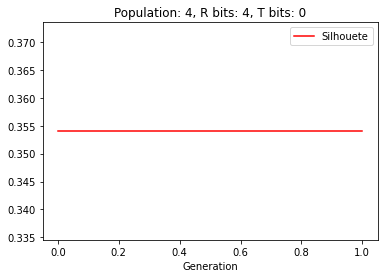

In [10]:
# testing = []

col_names = ['Generation', 'Population', 'Combination', 'R', 'T', 'Silhouete']
df_result = pd.DataFrame(columns = col_names)

pop_cache = {}

# initial population of random bitstring
pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
# assign the first combination as the best
best, best_eval = 0, 0



df_1 = df.copy()
    
for gen in range(n_iter):
    
    ### Deleting
    print("pop in gen {}: ".format(gen))
    for key,value in pop_cache.items():
        print(key,":",value)
    
    
    
    scores = []

    ts_before = time.time()
    ### cache
    for i in range(len(pop)):
        num = convert_to_decimal(pop[i])
        if num in pop_cache:
            scores.append(pop_cache.get(num))
        
        else:
            df_final = calc_score(df_1, pop[i])
            
    ### sort the list and pick the best 100 combination into the next population
    pop = [x for _, x in sorted(zip(scores, pop), reverse = True)]
    scores = sorted(scores, reverse = True)
    pop = pop[:n_pop]
    scores = scores[:n_pop]
    
    for i in range(n_pop):
    ### Get the best combination and score
        if scores[i] > best_eval:
            best, best_eval = pop[i], scores[i]

    
    ts_after = time.time()
    ts = ts_after - ts_before
    
    print(f'Gen: {gen}, R = {best[:label_mask]}, T = {best[label_mask:]}, Silhouete Score(n=3): {round(best_eval,4)}, Time Taken: {round(ts, 2)}s')
    
    df_result.loc[gen, 'Generation'] = gen
    df_result.loc[gen, 'Population'] = len(pop)
    df_result.loc[gen, 'Combination'] = best
    df_result.loc[gen, 'R'] = best[:label_mask]
    df_result.loc[gen, 'T'] = best[label_mask:]
    df_result.loc[gen, 'Silhouete'] = best_eval
    
    # select parents
    selected = [selection(pop, scores) for _ in range(n_pop)]  
    
    children = []
    
    for i in range(0, n_pop, 2):
        # get selected parents in pairs
        p1, p2 = selected[i], selected[i+1]
        
        for c in crossover(p1, p2, r_cross):

            # mutation
            mutation(c, r_mut)
            
            # store for next generation
            children.append(c)

    # replace population
    pop = pop + children
    
    
if os.path.exists(output):
    shutil.rmtree(output)

if not os.path.exists(output):
    os.makedirs(output)
    
  
df_result.plot(kind='line',x='Generation',y='Silhouete',color='red')
plt.title("Population: {}, R bits: {}, T bits: {}".format(n_pop, label_mask, (n_bits-label_mask)))
plt.savefig('{}/output.png'.format(output))
plt.show()


df_result.to_csv('{}/out.csv'.format(output), index=False)  
df_final.to_csv('{}/final_output.csv'.format(output), index=False)  
